In [5]:
# Import necessary libraries
import os
import shutil
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import timm


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
num_classes = 10  
model = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=num_classes)
model.load_state_dict(torch.load('vit_medical_image_classification_large.pth'))
model = model.to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

In [8]:
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load validation dataset
val_dataset = datasets.ImageFolder(root='D:\\CVPI\\Dataset\\validation', transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Initialize lists for predictions and labels
all_preds = []
all_labels = []
misclassified_path = []

In [10]:
import torch
import numpy as np

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Evaluation loop
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images, labels = images.to(device), labels.to(device)
        logits = model(images)  # Get the logits
        probs = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities

        all_preds.extend(probs.cpu().numpy())  # Store probabilities
        all_labels.extend(labels.cpu().numpy())  # Store true labels

# Convert to numpy arrays
all_preds = np.array(all_preds)  # Shape: (num_samples, num_classes)
all_labels = np.array(all_labels)  # Shape: (num_samples,)


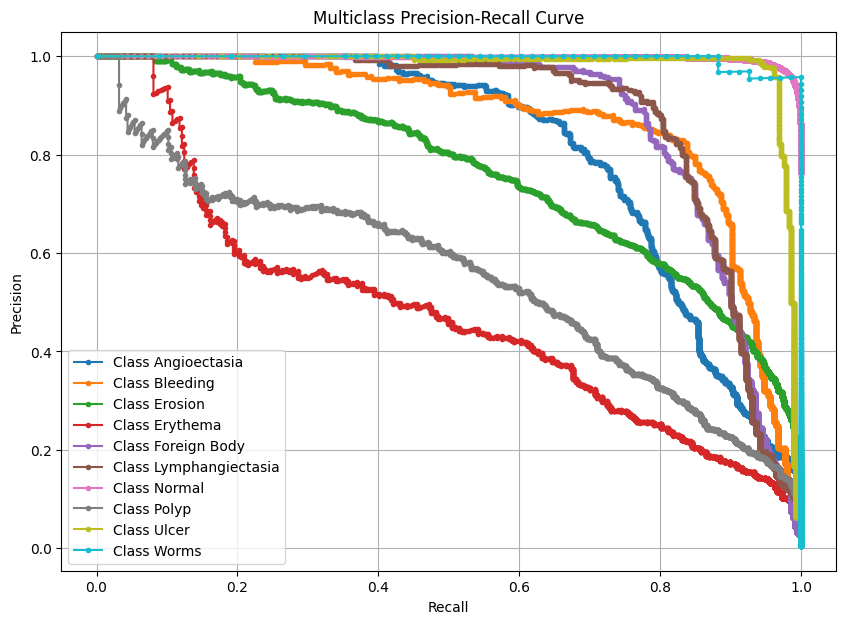

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Example class names
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 
               'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

# Binarize the output labels
y_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))

# Initialize a figure
plt.figure(figsize=(10, 7))

# Loop through each class to calculate and plot Precision-Recall
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], all_preds[:, i])  # Use probabilities for precision-recall calculation

    # Plotting each class's Precision-Recall curve
    plt.plot(recall, precision, marker='.', label=f'Class {class_names[i]}')

# Adding labels and title
plt.title('Multiclass Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()


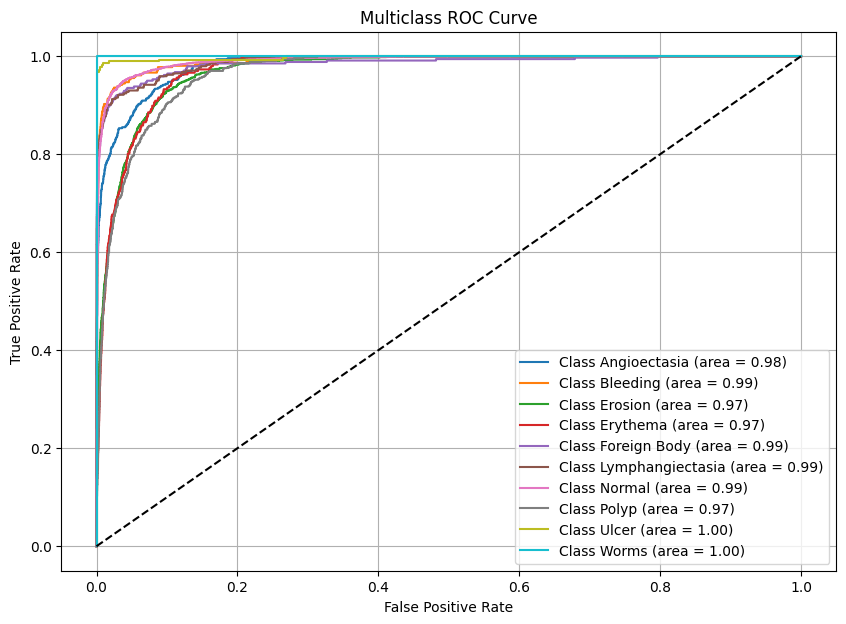

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming you have the following class names
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 
               'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

# Binarize the output labels
y_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))

# Initialize a figure
plt.figure(figsize=(10, 7))

# Loop through each class to calculate and plot ROC curve
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_preds[:, i])  # Use probabilities for ROC calculation
    roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve

    # Plotting each class's ROC curve
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


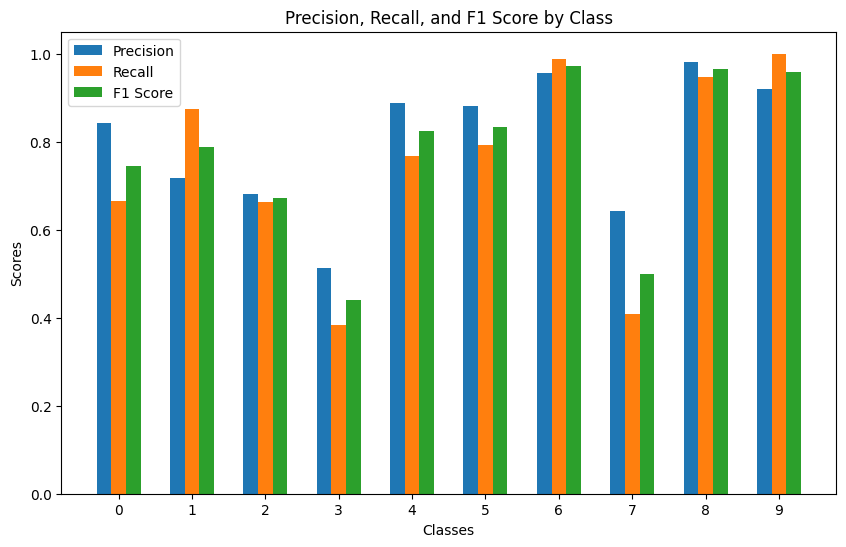

In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Calculate precision, recall, f1-score, and support
report = classification_report(all_labels, np.argmax(all_preds, axis=1), output_dict=True)

# Extract metrics for each class
precision = []
recall = []
f1 = []
class_names = []

for class_name in report.keys():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        precision.append(report[class_name]['precision'])
        recall.append(report[class_name]['recall'])
        f1.append(report[class_name]['f1-score'])
        class_names.append(class_name)

# Convert to numpy arrays for easier manipulation
precision = np.array(precision)
recall = np.array(recall)
f1 = np.array(f1)

# Create a bar graph
x = np.arange(len(class_names))
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1, width, label='F1 Score')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

plt.show()


Macro Average Precision: 0.8022197103538401
Macro Average Recall: 0.7492142897275959
Macro Average F1 Score: 0.7694310727458605


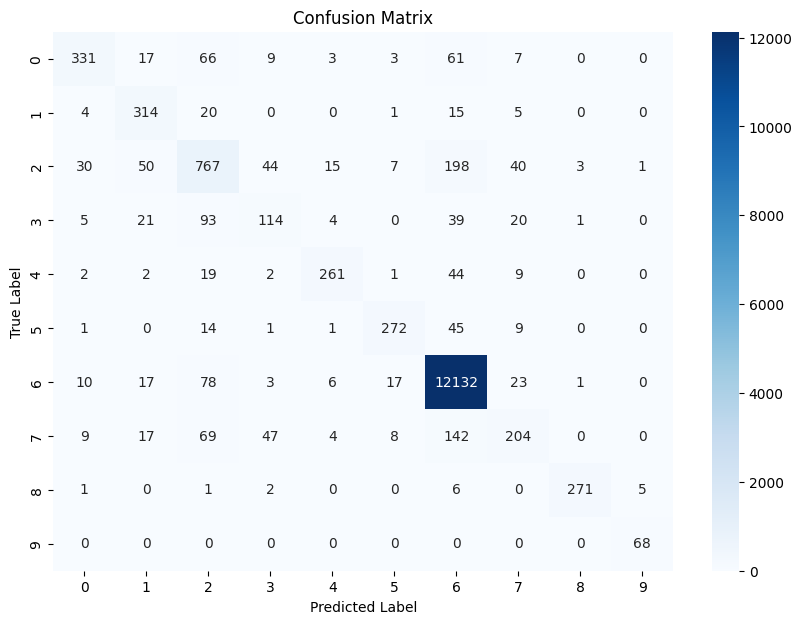

In [14]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the following lists: all_labels (true labels) and all_preds (predicted probabilities)
# all_labels: True class labels
# all_preds: Predicted probabilities (from your model)

# Get the predicted classes from probabilities
predicted_classes = np.argmax(all_preds, axis=1)

# Generate the classification report
report = classification_report(all_labels, predicted_classes, output_dict=True)

# Extract precision, recall, and F1 scores
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

print("Macro Average Precision:", precision)
print("Macro Average Recall:", recall)
print("Macro Average F1 Score:", f1_score)

# Print confusion matrix
conf_matrix = confusion_matrix(all_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Class: 0 - Precision: 0.8422, Recall: 0.6660, F1 Score: 0.7438
Class: 1 - Precision: 0.7169, Recall: 0.8747, F1 Score: 0.7880
Class: 2 - Precision: 0.6806, Recall: 0.6641, F1 Score: 0.6722
Class: 3 - Precision: 0.5135, Recall: 0.3838, F1 Score: 0.4393
Class: 4 - Precision: 0.8878, Recall: 0.7676, F1 Score: 0.8233
Class: 5 - Precision: 0.8803, Recall: 0.7930, F1 Score: 0.8344
Class: 6 - Precision: 0.9566, Recall: 0.9874, F1 Score: 0.9718
Class: 7 - Precision: 0.6435, Recall: 0.4080, F1 Score: 0.4994
Class: 8 - Precision: 0.9819, Recall: 0.9476, F1 Score: 0.9644
Class: 9 - Precision: 0.9189, Recall: 1.0000, F1 Score: 0.9577


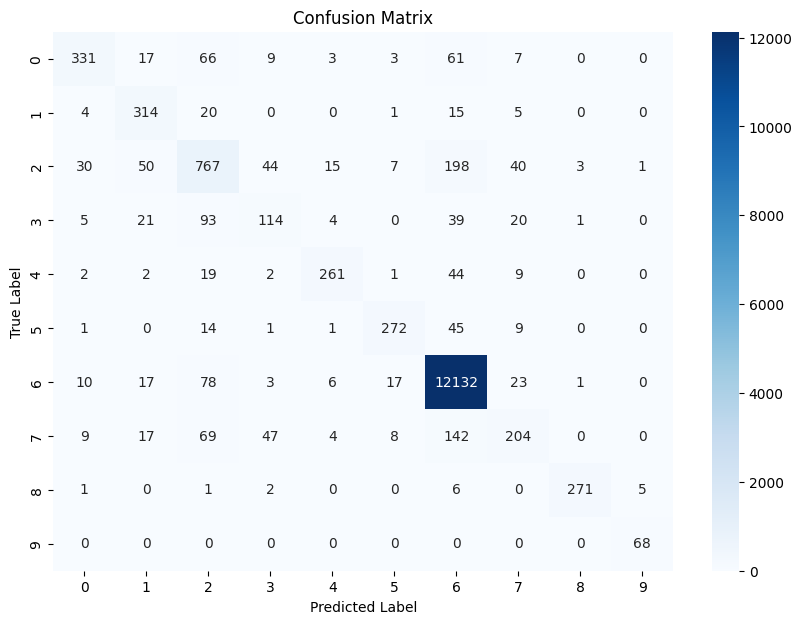

In [15]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the following lists: all_labels (true labels) and all_preds (predicted probabilities)
# all_labels: True class labels
# all_preds: Predicted probabilities (from your model)

# Get the predicted classes from probabilities
predicted_classes = np.argmax(all_preds, axis=1)

# Generate the classification report
report = classification_report(all_labels, predicted_classes, output_dict=True)

# Extract precision, recall, and F1 scores for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        precision = metrics['precision']
        recall = metrics['recall']
        f1_score = metrics['f1-score']
        print(f"Class: {class_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

# Print confusion matrix
conf_matrix = confusion_matrix(all_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
